In [4]:
%pip install --user pandas scipy numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import time
import numpy as np
from scipy.stats import chisquare
import collections
import math
import matplotlib.pyplot as plt
import glob
import bz2
from scipy.integrate import quad
from scipy.special import gamma
from scipy.stats import chi2
from scipy.stats import kstest
from collections import Counter
import collections
import os

#### Data preparation, segmenting the dataset based on the frequencies of the logarithmic values 

In [6]:
# Convert a string to a number; return None if conversion fails
def convert_to_number(s):
    try:
        return float(s)
    except ValueError:
        return None

# Extract numbers from the file
numbers = []

# Retrieve all .trans files, change if needed
filenames = glob.glob('/mnt/data/exomol/exomol3_data/TiO/49Ti-16O/Toto/*.trans.bz2')
filenames = sorted(filenames)

# ## For sample input
# # get current repository
# current_directory = os.getcwd()
# filenames = glob.glob(os.path.join(current_directory, '*.trans.bz2'))

# Read each file and extract numbers
for filename in filenames:
    with bz2.open(filename, 'r') as file:
        for line in file:
            data = line.strip().split()
            number = convert_to_number(data[2])
            if number is not None:
                numbers.append(number)

# Compute the logarithm of each number
log_numbers = [math.log10(num) for num in numbers if num > 0]  # Ensure the number is greater than 0 before taking the log


# Count the frequency of each unique log value
log_freq = Counter(log_numbers)

# Sort the unique log values based on their frequencies
sorted_log_values = sorted(log_freq.keys(), key=lambda x: log_freq[x])

# Determine the number of groups
num_bins = 8  # can adjust this as needed

# Calculate the total frequency and the approximate frequency per group
total_freq = sum(log_freq.values())
freq_per_group = total_freq // num_bins

# Determine the boundaries for each group based on cumulative frequencies
boundaries = []
cumulative_freq = 0
for log_val in sorted_log_values:
    cumulative_freq += log_freq[log_val]
    if cumulative_freq >= freq_per_group:
        boundaries.append(log_val)
        cumulative_freq = 0
boundaries.append(sorted_log_values[-1])  # Add the maximum value as the last boundary

# Use the boundaries to group the original numbers
groups = {}
for i in range(len(boundaries) - 1):
    lower_bound = boundaries[i]
    upper_bound = boundaries[i+1]
    group = [num for num in numbers if lower_bound <= np.log10(num) <= upper_bound]
    groups[f'group_{i+1}'] = group


#### Plot visulisation for each group on a log scale

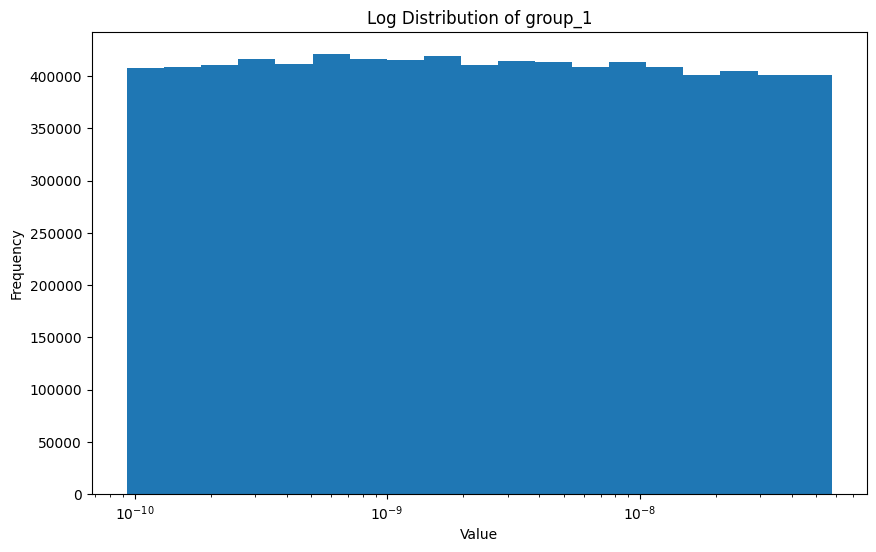

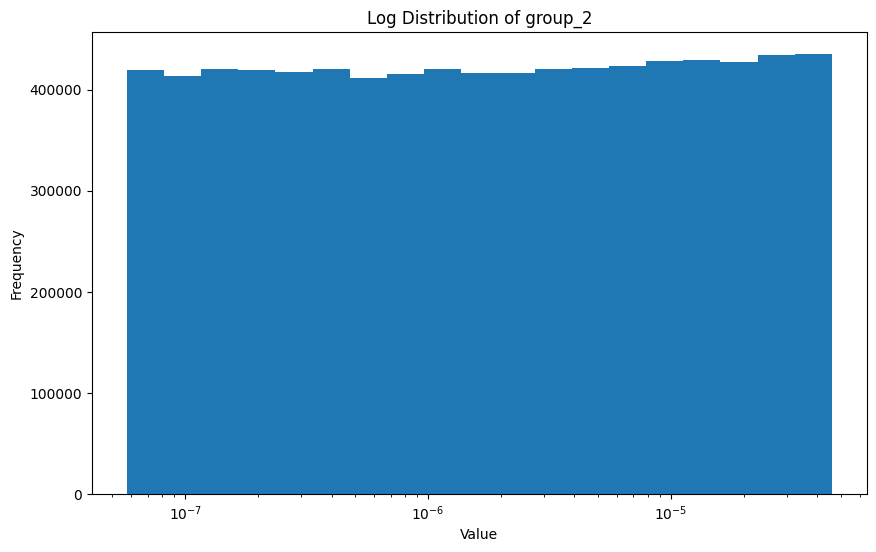

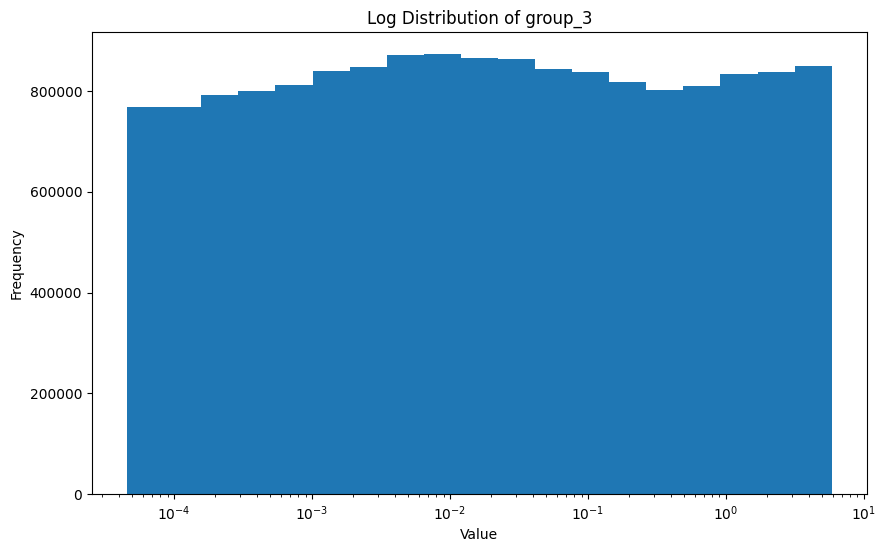

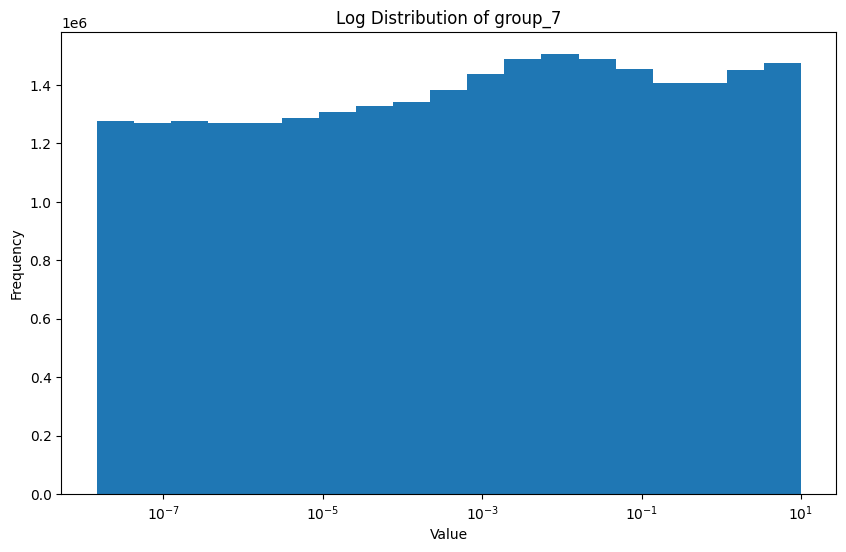

In [7]:
# Loop through each group and plot its histogram
for group_name, group in groups.items():
    # Check if the group is not empty
    if group:
        plt.figure(figsize=(10, 6))
        
        # Visualization of the distribution on a logarithmic scale
        plt.hist(group, bins=np.logspace(np.log10(min(group)), np.log10(max(group)), 20))
        plt.xscale('log')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Log Distribution of {group_name}')
        plt.show()

In [8]:
# Define a function to extract the leading digit from a string
def get_leading_digit(s):
    # Strip leading zeros
    s = s.lstrip('0')
    
    # If the first character is a decimal point, find the first non-zero digit after it
    if s and s[0] == '.':
        s = s[1:].lstrip('0')
    
    # Return the first non-zero digit, or 0 if no such digit is found
    return int(s[0]) if s else 0

# Dictionary to store the frequencies of leading digits for each group
group_frequencies = {}

# Check each group and extract leading digits if its size is larger than 1000
for group_name, group in groups.items():
    if len(group) > 1000:
        leading_digits_transformed = [get_leading_digit(str(num)) for num in group]
        
        # Count the frequency of each leading digit in the transformed dataset
        leading_digit_counts_transformed = collections.Counter(leading_digits_transformed)
        
        total_count = sum(leading_digit_counts_transformed.values())
        observed_frequencies = dict(sorted(leading_digit_counts_transformed.items()))
        
        # Store the frequencies in the dictionary
        group_frequencies[group_name] = observed_frequencies

        # Print the frequencies for the group
        print(f"Frequencies for {group_name}:")
        print(observed_frequencies)
        print("-" * 50)


Frequencies for group_1:
{1: 2525713, 2: 1472492, 3: 1049700, 4: 808603, 5: 615241, 6: 378272, 7: 327626, 8: 290798, 9: 339761}
--------------------------------------------------
Frequencies for group_2:
{1: 2493676, 2: 1463421, 3: 1041343, 4: 702161, 5: 481798, 6: 549766, 7: 478381, 8: 420075, 9: 378066}
--------------------------------------------------
Frequencies for group_3:
{1: 4647204, 2: 2723538, 3: 1938813, 4: 1611314, 5: 1420281, 6: 1012985, 7: 885751, 8: 786511, 9: 705892}
--------------------------------------------------
Frequencies for group_7:
{1: 7529499, 2: 4672898, 3: 3321180, 4: 2577820, 5: 2103743, 6: 1776459, 7: 1548765, 8: 1369141, 9: 1229769}
--------------------------------------------------


#### Perform chi-square analysis and plot figures for each group

Results for group_1:
Chi-square statistic for Benford's Law expected frequency: 134118.7692003788
P-value for Benford's Law expected frequency: 0.0
group_1 MAD: 0.011350059677201482
--------------------------------------------------


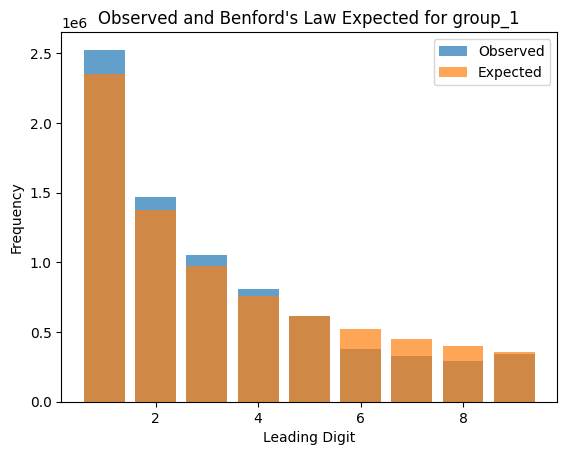

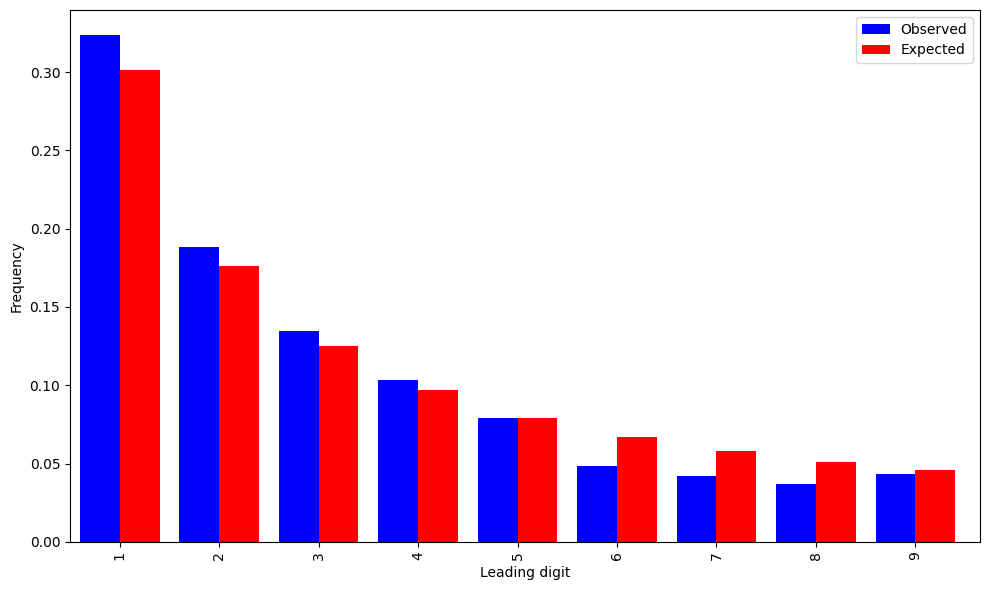

Results for group_2:
Chi-square statistic for Benford's Law expected frequency: 51549.77582685559
P-value for Benford's Law expected frequency: 0.0
group_2 MAD: 0.006279314150104663
--------------------------------------------------


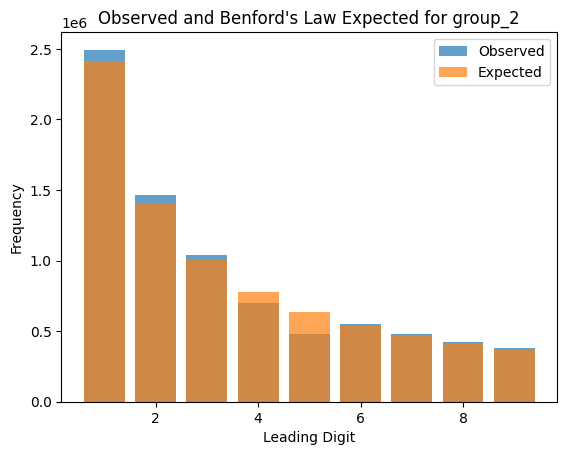

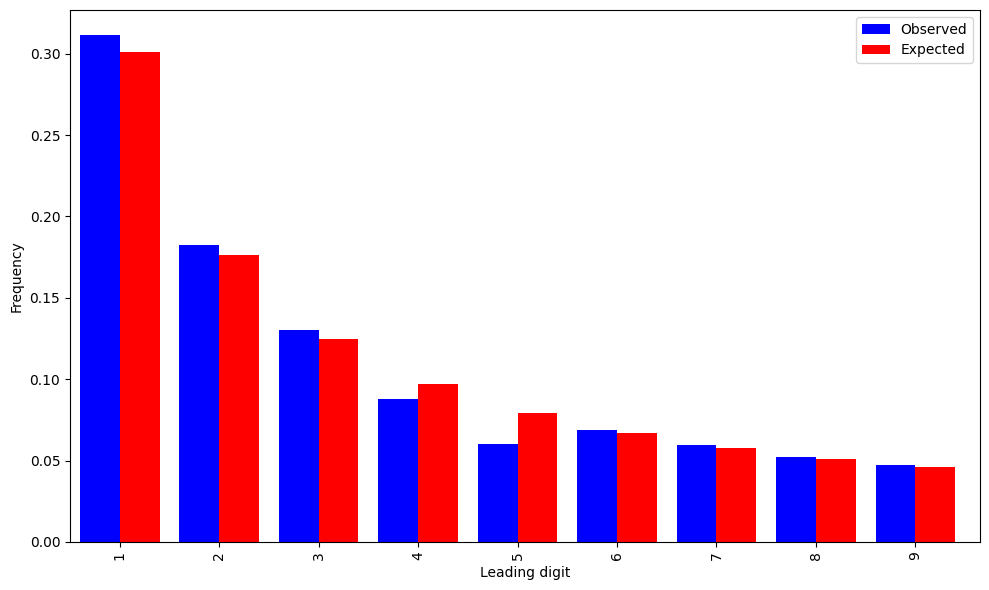

Results for group_3:
Chi-square statistic for Benford's Law expected frequency: 35208.846897402174
P-value for Benford's Law expected frequency: 0.0
group_3 MAD: 0.0036905899165179095
--------------------------------------------------


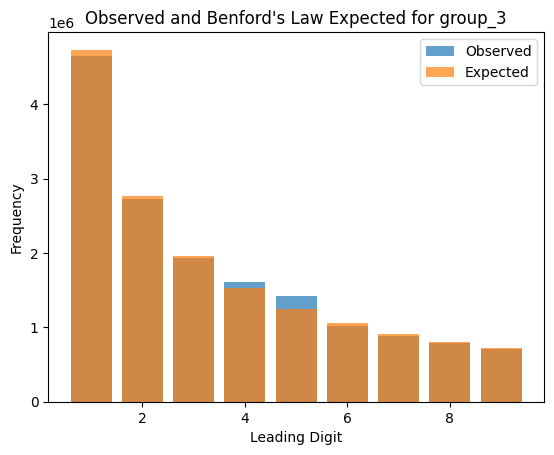

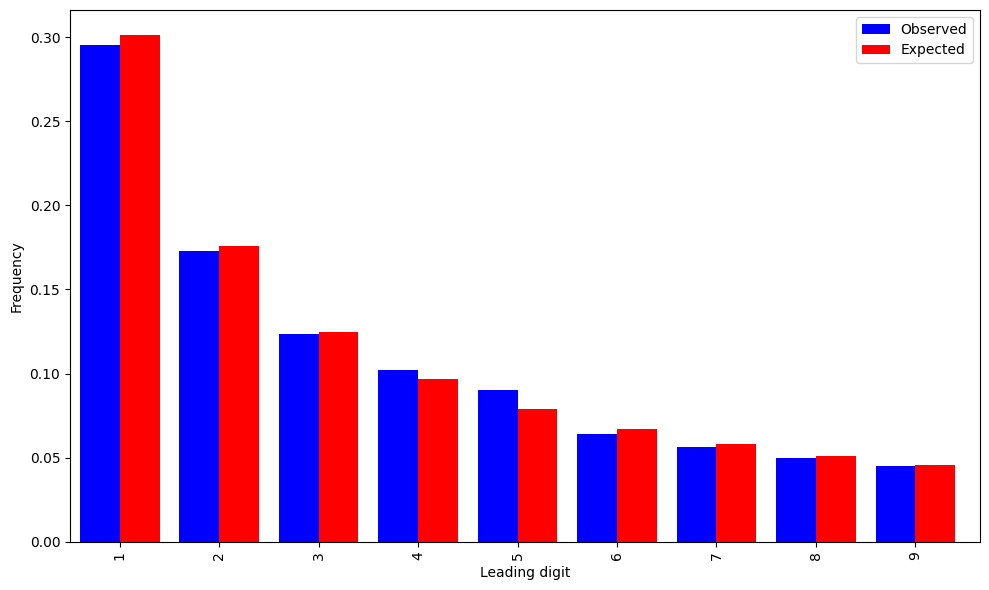

Results for group_7:
Chi-square statistic for Benford's Law expected frequency: 20809.924815633105
P-value for Benford's Law expected frequency: 0.0
group_7 MAD: 0.002859255688321735
--------------------------------------------------


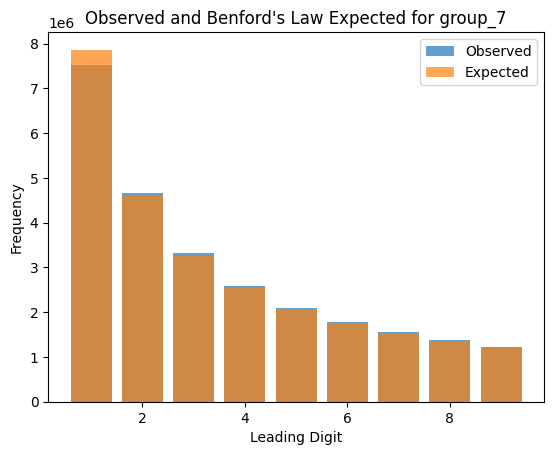

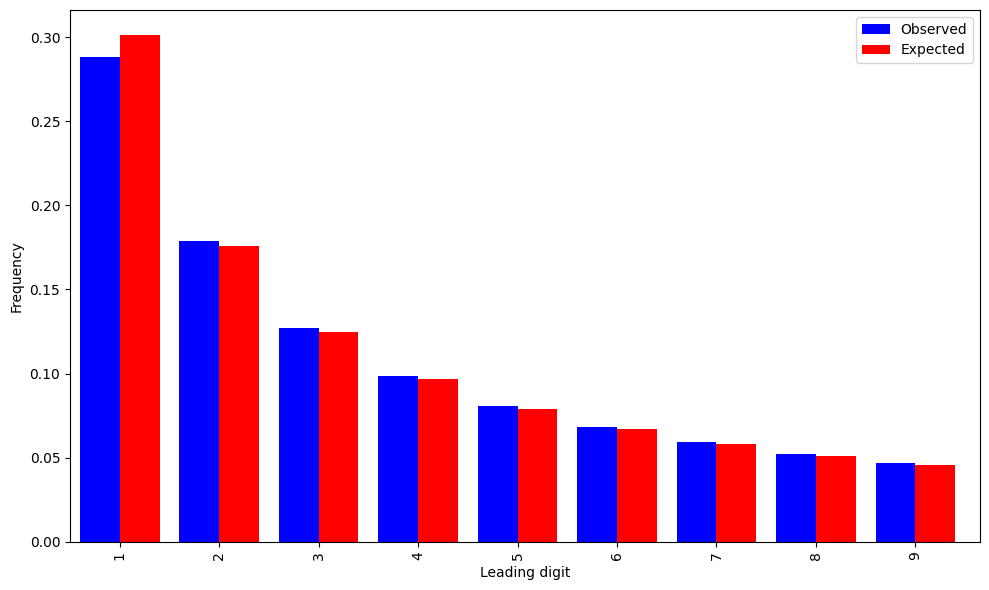

In [10]:
# Perform chi-square analysis and plot figures for each group
for group_name, observed_frequencies in group_frequencies.items():
    total_count = sum(observed_frequencies.values())
    
    # Calculate the expected frequency for each leading digit under the assumption of Benford's Law
    expected_frequencies_ben = {i: total_count * math.log10(1 + 1/i) for i in range(1, 10)}

    # Perform a chi-square test
    chi2_ben, p_ben = chisquare(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

    # Convert the frequencies to ratios
    observed_ratios = {k: v / total_count for k, v in observed_frequencies.items()}

    # Calculate expected frequencies according to Benford's law
    expected_frequencies = {i: math.log10(1 + 1 / i) for i in range(1, 10)}

    # Calculate the expected frequency for each leading digit under the assumption of Benford's Law
    probability_distribution_ben = expected_frequencies

    # Calculate the frequency for each leading digit under the observed dataset
    probability_distribution_obv = observed_ratios

    # Compute the MAD
    MAD = sum(abs(probability_distribution_obv[d] - probability_distribution_ben[d]) for d in range(1, 10)) / 9

    # Print the results for Benford's Law
    print(f"Results for {group_name}:")
    print(f"Chi-square statistic for Benford's Law expected frequency: {chi2_ben}")
    print(f"P-value for Benford's Law expected frequency: {p_ben}")
    print(f'{group_name} MAD: {MAD}')
    print("-" * 50)

    # Create a bar plot for Benford's Law
    plt.title(f'Observed and Benford\'s Law Expected for {group_name}')
    plt.bar(range(1, 10), [observed_frequencies.get(i, 0) for i in range(1, 10)], alpha=0.7, label='Observed')
    plt.bar(range(1, 10), [expected_frequencies_ben[i] for i in range(1, 10)], alpha=0.7, label='Expected')
    plt.xlabel('Leading Digit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Create a dataframe from the observed and expected ratios
    df = pd.DataFrame({'observed': observed_ratios, 'expected': expected_frequencies})

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    df['observed'].plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Observed')
    df['expected'].plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Expected')
    ax.set_xlabel('Leading digit')
    ax.set_ylabel('Frequency')
    ax.set_xlim(left=-0.5)  
    plt.tight_layout() 
    plt.legend()
    plt.show()


#### Dividing the dataset into equal groups

In [11]:
# split dataset equally
# Determine bin edges for uniform distribution of logarithmic values
num_bins = 8  # can adjust this as needed
_, bin_edges = np.histogram(log_numbers, bins=num_bins)

# Use bin edges to group the original numbers
groups = {}
for i in range(len(bin_edges) - 1):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i+1]
    group = [num for num in numbers if lower_bound <= math.log10(num) <= upper_bound]
    groups[f'group_{i+1}'] = group

# Sort the log_numbers
sorted_log_numbers = sorted(log_numbers)

# Calculate the size of each group
group_size = len(sorted_log_numbers) // num_bins

# Determine the boundaries for each group
boundaries = [sorted_log_numbers[i * group_size] for i in range(num_bins)]
boundaries.append(sorted_log_numbers[-1])  # Add the maximum value as the last boundary

# Use the boundaries to group the original numbers
groups = {}
for i in range(len(boundaries) - 1):
    lower_bound = boundaries[i]
    upper_bound = boundaries[i+1]
    group = [num for num in numbers if lower_bound <= np.log10(num) <= upper_bound]
    groups[f'group_{i+1}'] = group

#### Plot visulisation for each group on a log scale

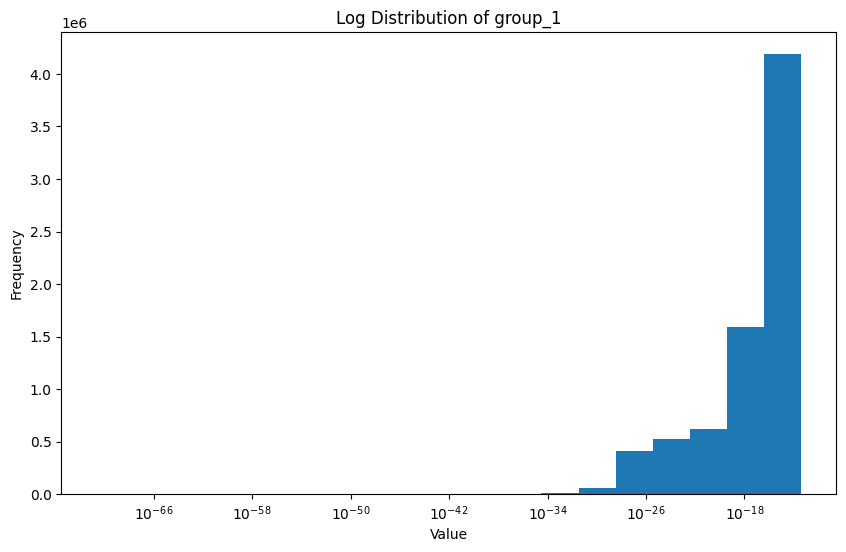

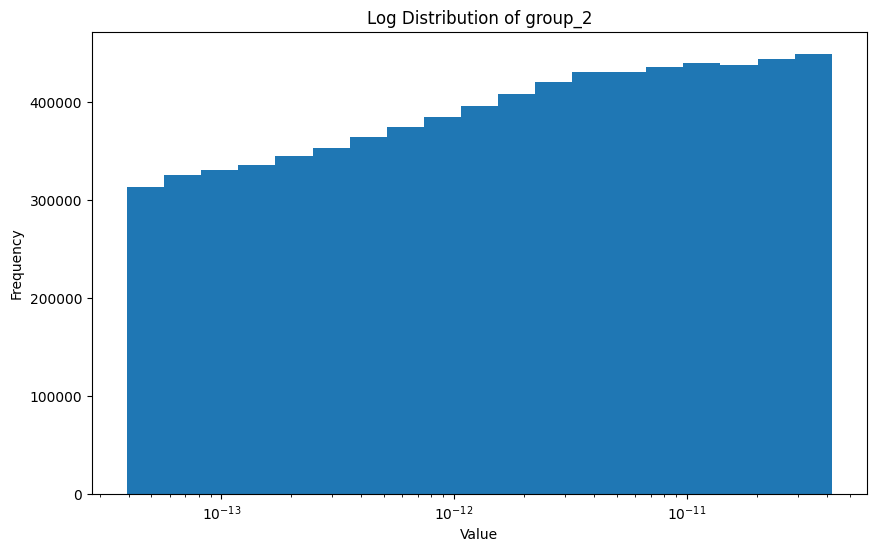

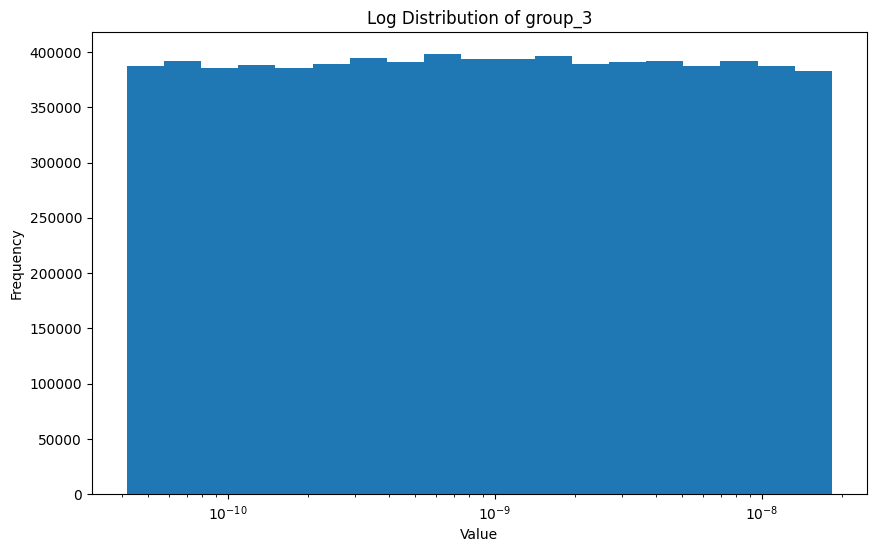

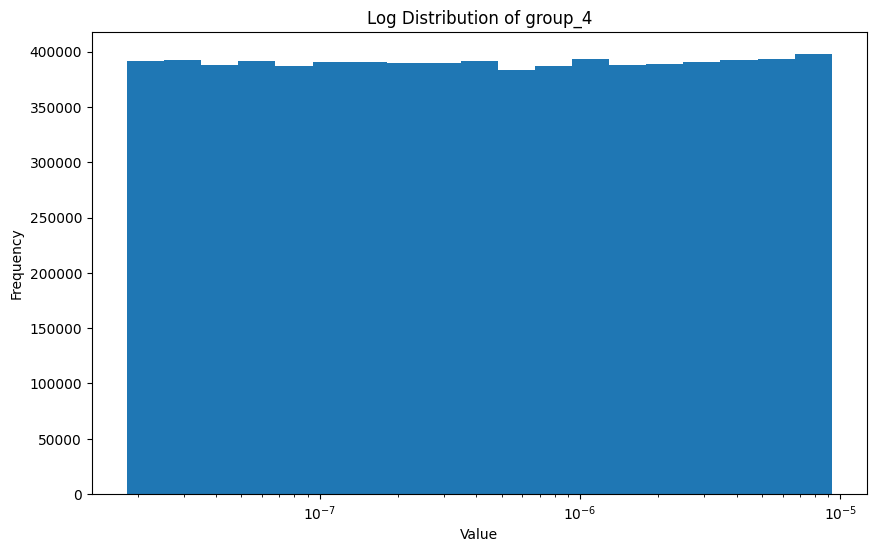

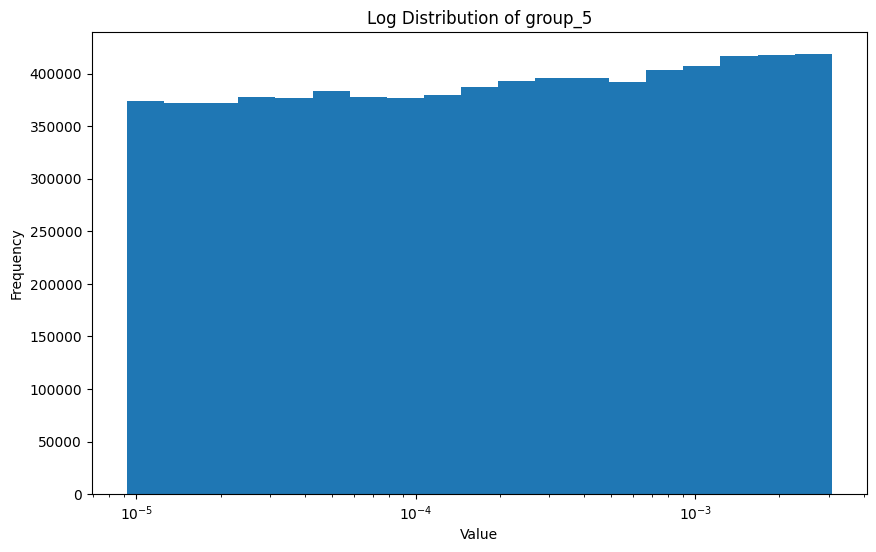

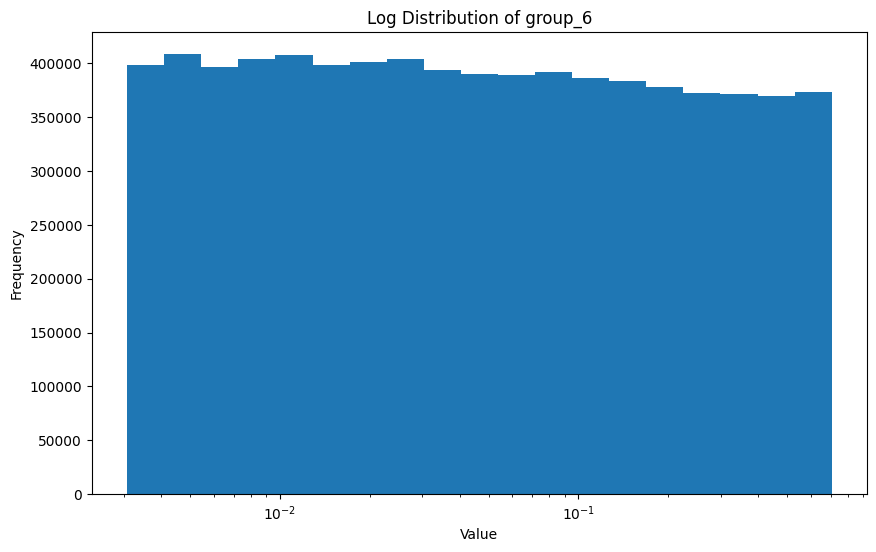

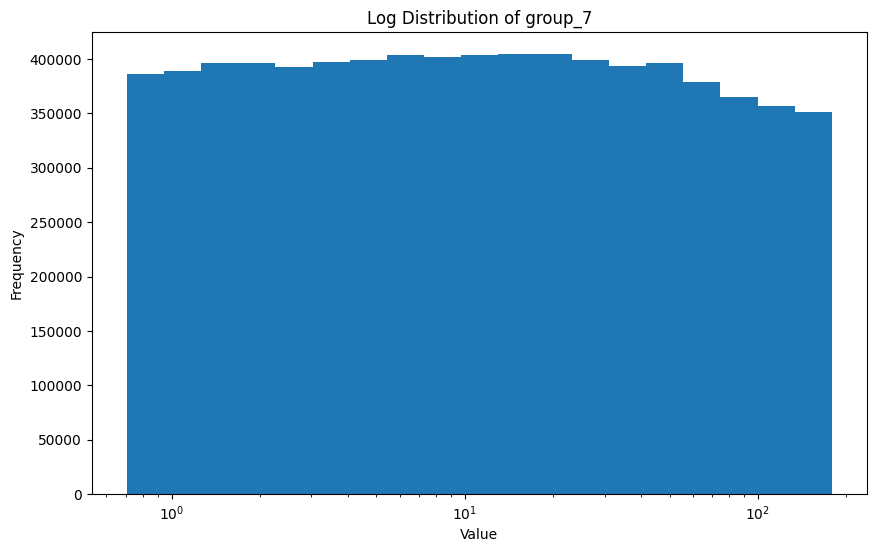

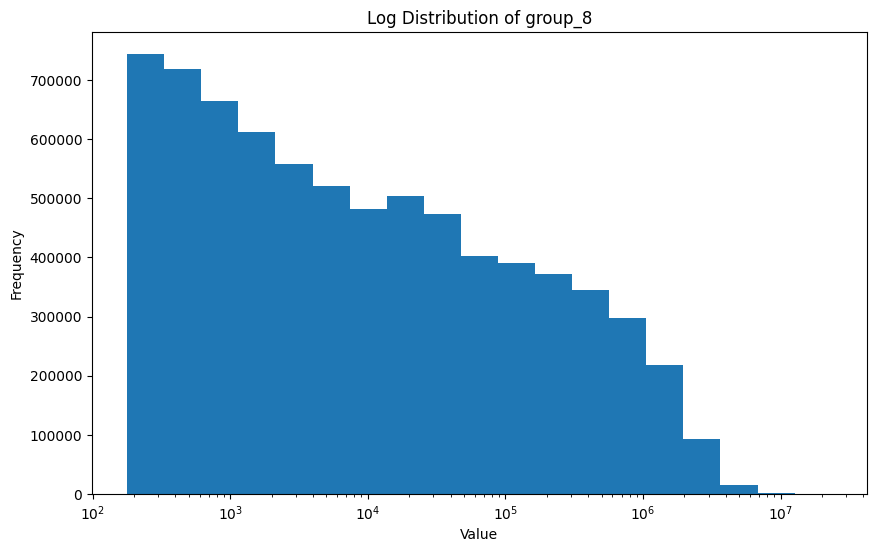

In [12]:
# Loop through each group and plot its histogram
for group_name, group in groups.items():
    # Check if the group is not empty
    if group:
        plt.figure(figsize=(10, 6))
        
        # Visualization of the distribution on a logarithmic scale
        plt.hist(group, bins=np.logspace(np.log10(min(group)), np.log10(max(group)), 20))
        plt.xscale('log')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Log Distribution of {group_name}')
        plt.show()

In [13]:

# Define a function to extract the leading digit from a string
def get_leading_digit(s):
    # Strip leading zeros
    s = s.lstrip('0')
    
    # If the first character is a decimal point, find the first non-zero digit after it
    if s and s[0] == '.':
        s = s[1:].lstrip('0')
    
    # Return the first non-zero digit, or 0 if no such digit is found
    return int(s[0]) if s else 0

# Dictionary to store the frequencies of leading digits for each group
group_frequencies = {}

# Check each group and extract leading digits if its size is larger than 1000
for group_name, group in groups.items():
    if len(group) > 1000:
        leading_digits_transformed = [get_leading_digit(str(num)) for num in group]
        
        # Count the frequency of each leading digit in the transformed dataset
        leading_digit_counts_transformed = collections.Counter(leading_digits_transformed)
        
        total_count = sum(leading_digit_counts_transformed.values())
        observed_frequencies = dict(sorted(leading_digit_counts_transformed.items()))
        
        # Store the frequencies in the dictionary
        group_frequencies[group_name] = observed_frequencies

        # Print the frequencies for the group
        print(f"Frequencies for {group_name}:")
        print(observed_frequencies)
        print("-" * 50)

print(group_frequencies)

Frequencies for group_1:
{1: 2257819, 2: 1407684, 3: 1025648, 4: 632560, 5: 531885, 6: 459877, 7: 406347, 8: 363475, 9: 330289}
--------------------------------------------------
Frequencies for group_2:
{1: 2219274, 2: 1338928, 3: 980318, 4: 730054, 5: 554631, 6: 476480, 7: 416393, 8: 368495, 9: 331007}
--------------------------------------------------
Frequencies for group_3:
{1: 2415366, 2: 986553, 3: 708676, 4: 757926, 5: 670664, 6: 567041, 7: 491394, 8: 432302, 9: 385701}
--------------------------------------------------
Frequencies for group_4:
{1: 1760366, 2: 1449085, 3: 1028900, 4: 796022, 5: 649051, 6: 549766, 7: 478381, 8: 420075, 9: 283946}
--------------------------------------------------
Frequencies for group_5:
{1: 2651503, 2: 1574577, 3: 765561, 4: 563657, 5: 462447, 6: 389579, 7: 339398, 8: 303017, 9: 365877}
--------------------------------------------------
Frequencies for group_6:
{1: 1900460, 2: 1102683, 3: 1134311, 4: 912906, 5: 740329, 6: 623406, 7: 379299, 8: 

#### Perform chi-square and MAD analysis, plot figures for each group

Results for group_1:
Chi-square statistic for Benford's Law expected frequency: 39270.034513822284
P-value for Benford's Law expected frequency: 0.0
group_1 MAD: 0.0067882437031174594
--------------------------------------------------


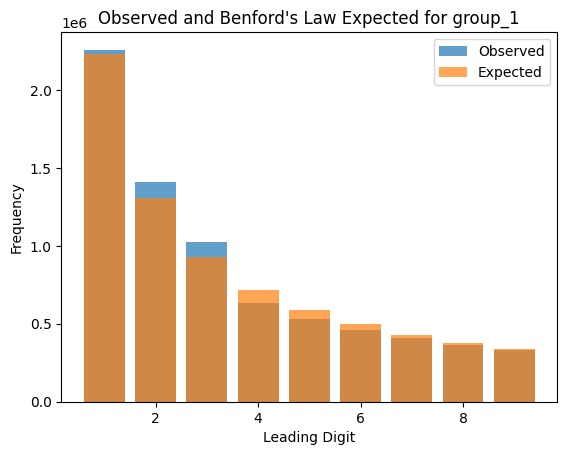

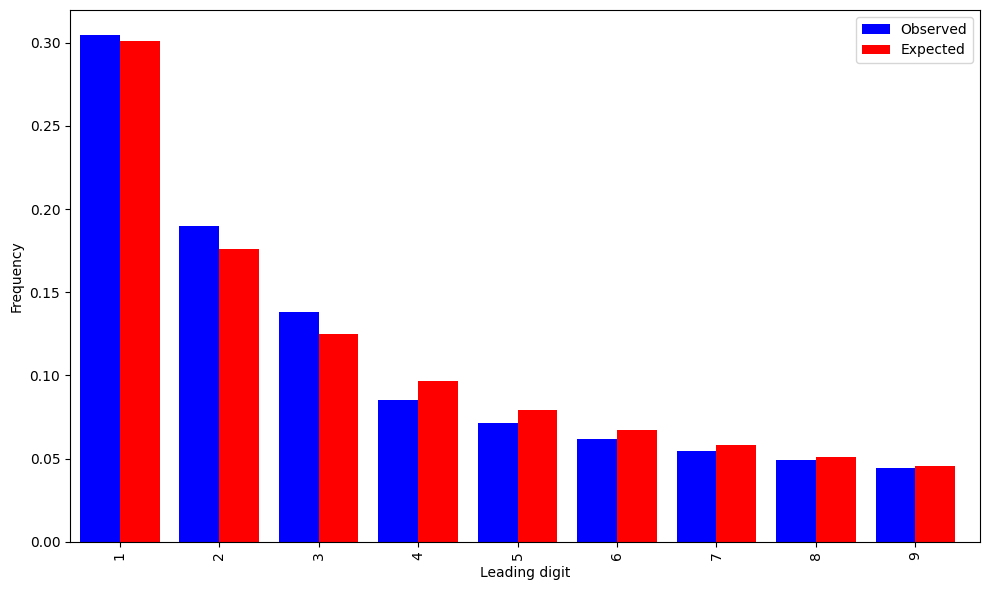

Results for group_2:
Chi-square statistic for Benford's Law expected frequency: 7776.874735709335
P-value for Benford's Law expected frequency: 0.0
group_2 MAD: 0.0029470694130709044
--------------------------------------------------


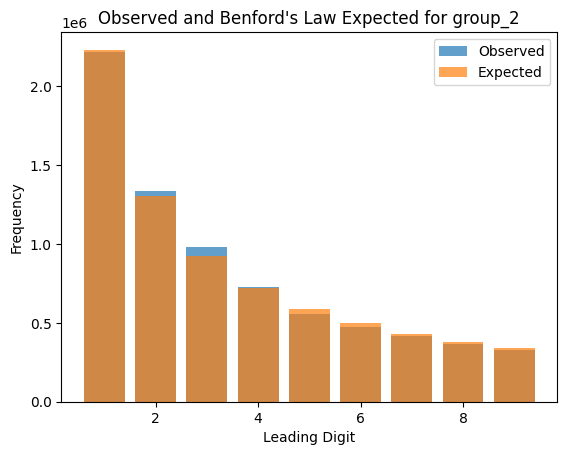

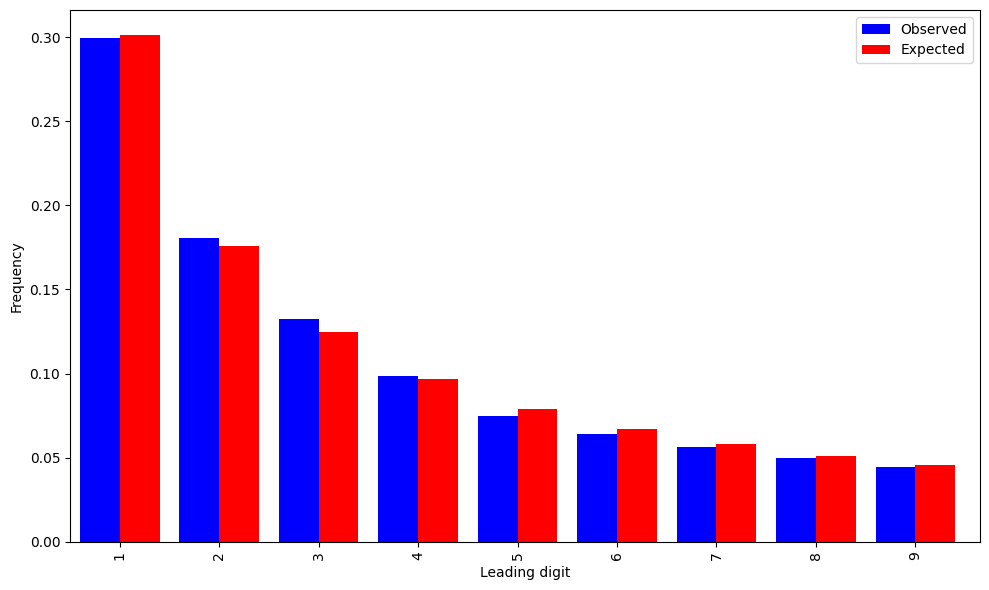

Results for group_3:
Chi-square statistic for Benford's Law expected frequency: 190824.0799641472
P-value for Benford's Law expected frequency: 0.0
group_3 MAD: 0.01609502771036287
--------------------------------------------------


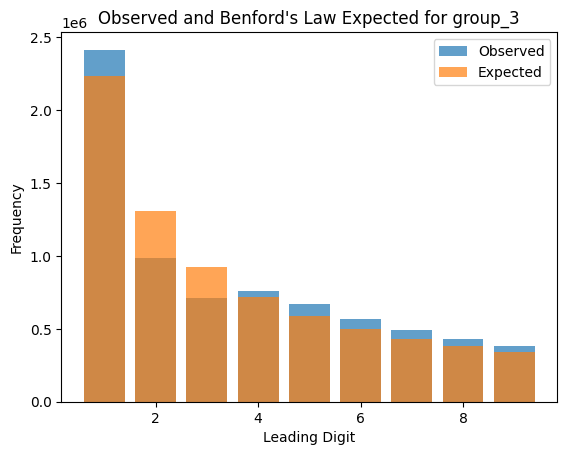

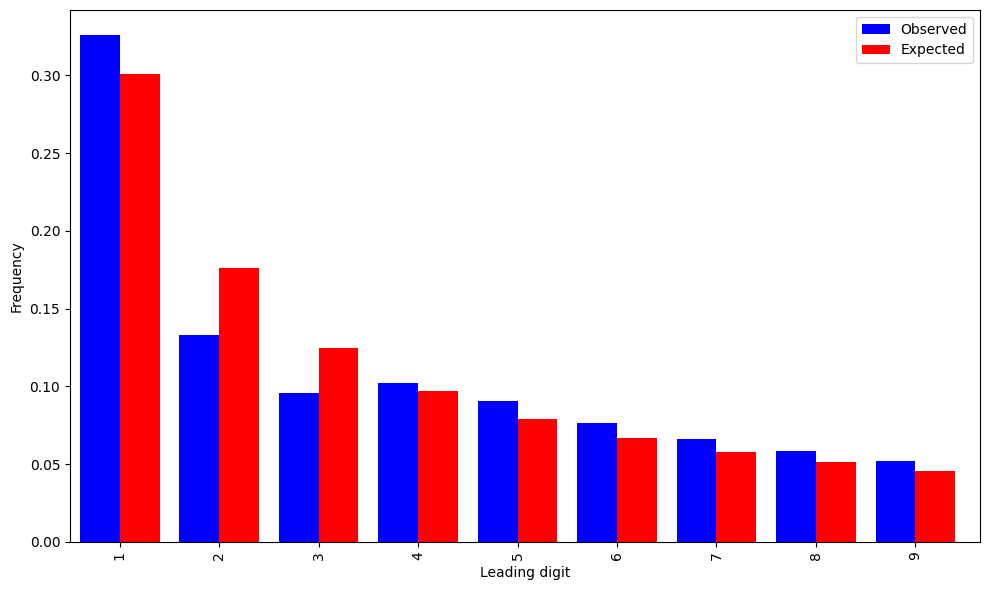

Results for group_4:
Chi-square statistic for Benford's Law expected frequency: 166238.65701994015
P-value for Benford's Law expected frequency: 0.0
group_4 MAD: 0.01580221507295175
--------------------------------------------------


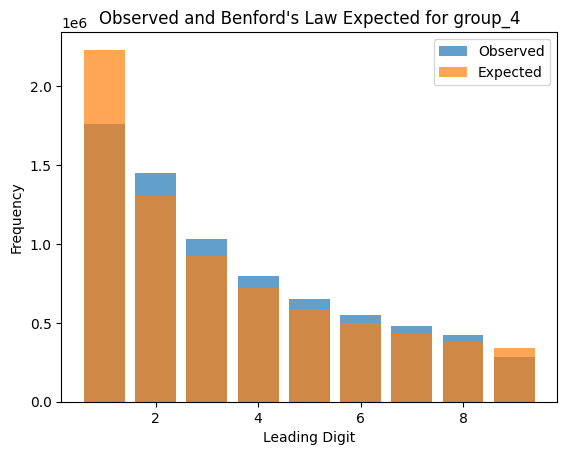

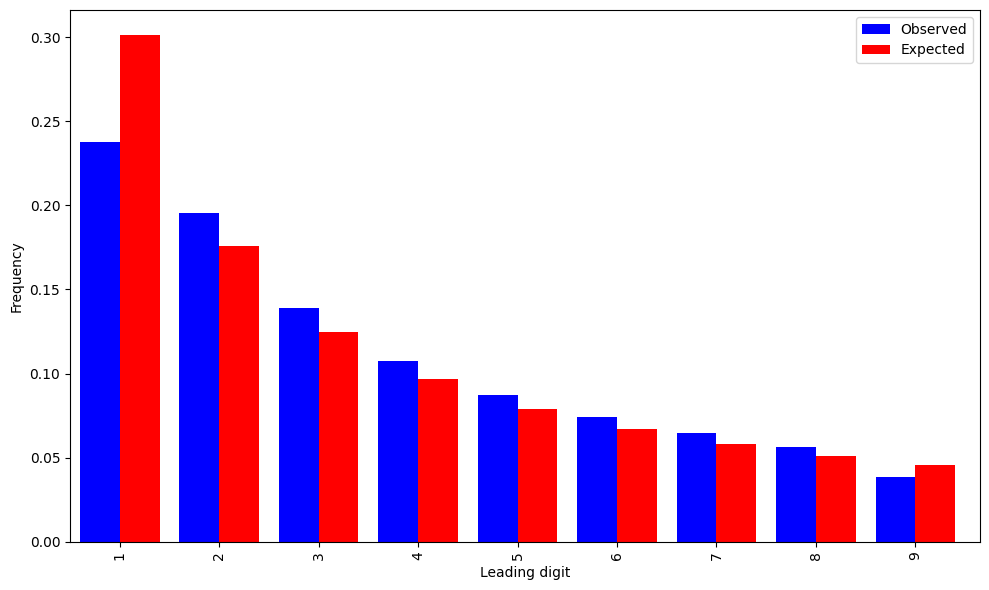

Results for group_5:
Chi-square statistic for Benford's Law expected frequency: 281446.710243147
P-value for Benford's Law expected frequency: 0.0
group_5 MAD: 0.02141094356195851
--------------------------------------------------


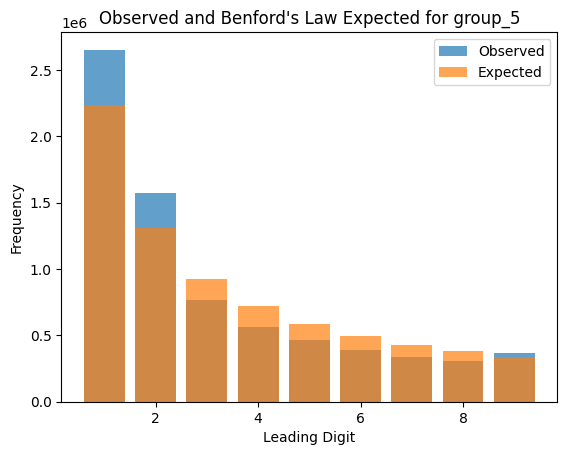

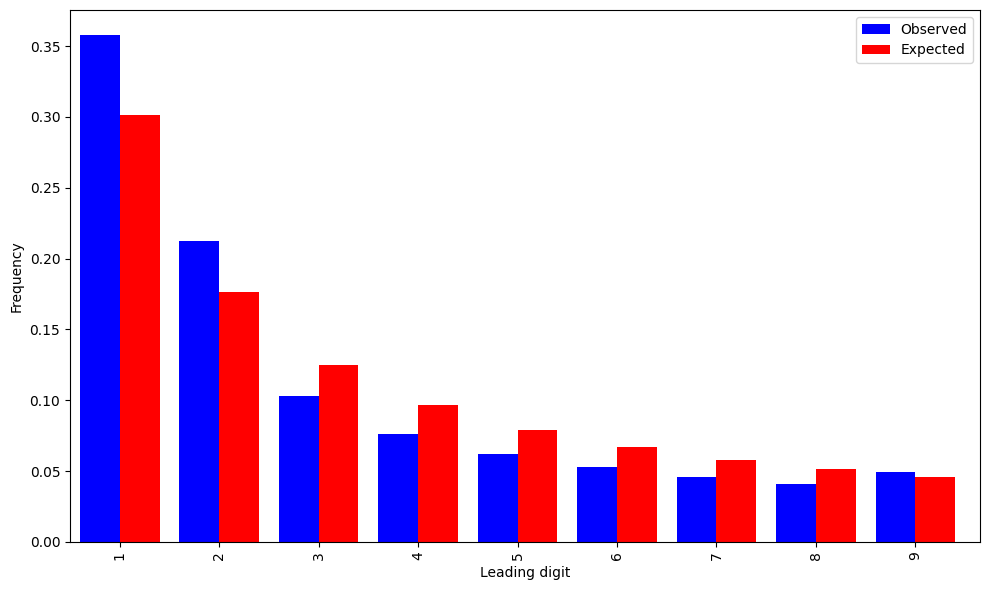

Results for group_6:
Chi-square statistic for Benford's Law expected frequency: 271405.8786727844
P-value for Benford's Law expected frequency: 0.0
group_6 MAD: 0.02044302853065138
--------------------------------------------------


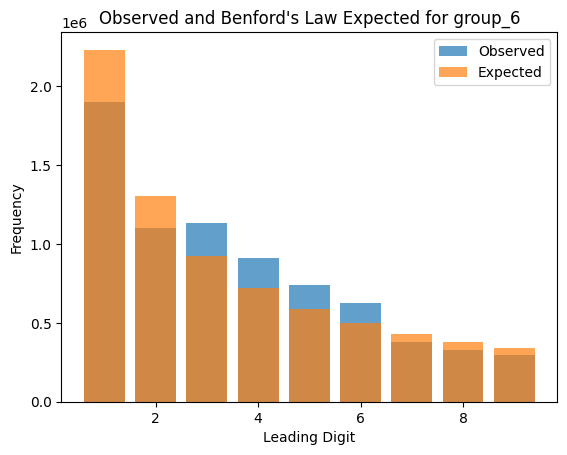

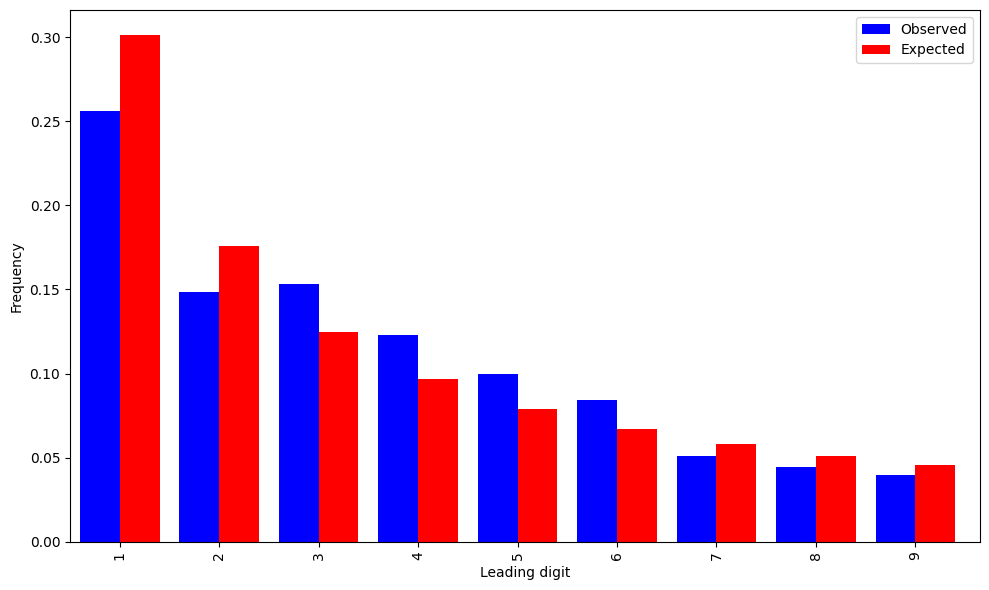

Results for group_7:
Chi-square statistic for Benford's Law expected frequency: 216675.55554822373
P-value for Benford's Law expected frequency: 0.0
group_7 MAD: 0.018807818507134883
--------------------------------------------------


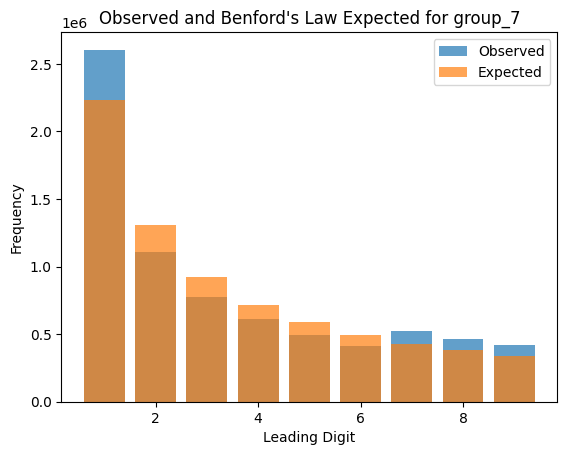

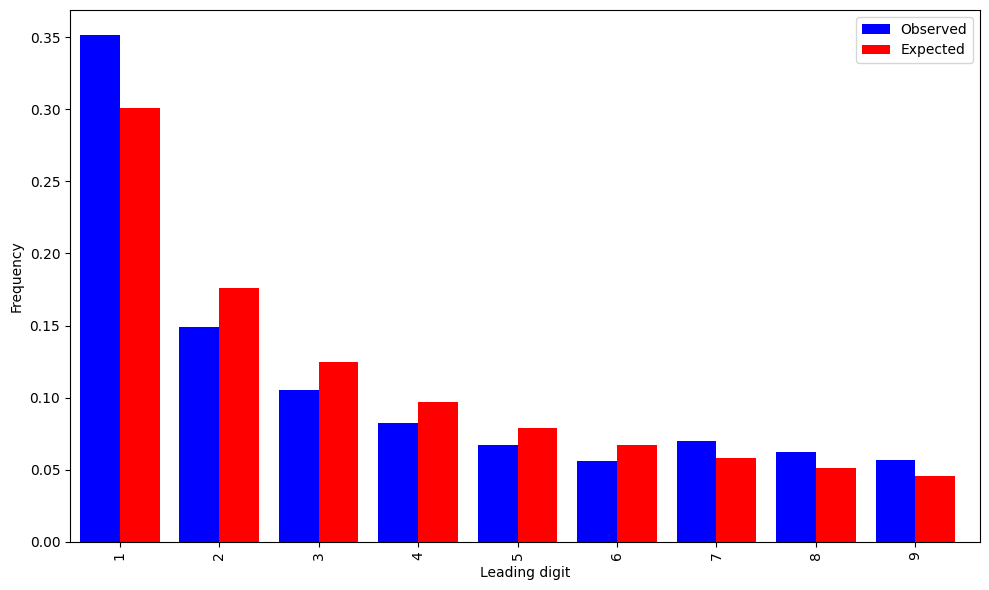

Results for group_8:
Chi-square statistic for Benford's Law expected frequency: 59022.25478482027
P-value for Benford's Law expected frequency: 0.0
group_8 MAD: 0.008808246447788456
--------------------------------------------------


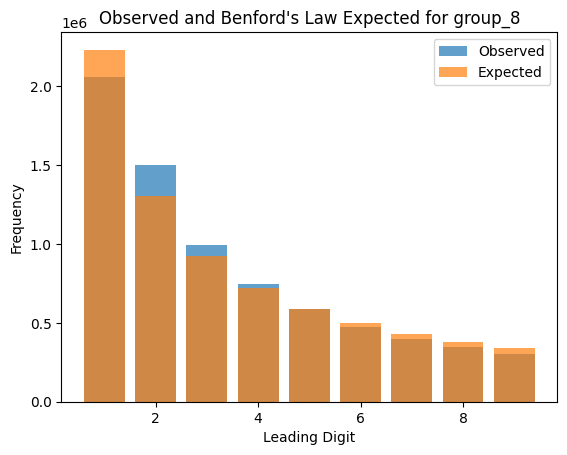

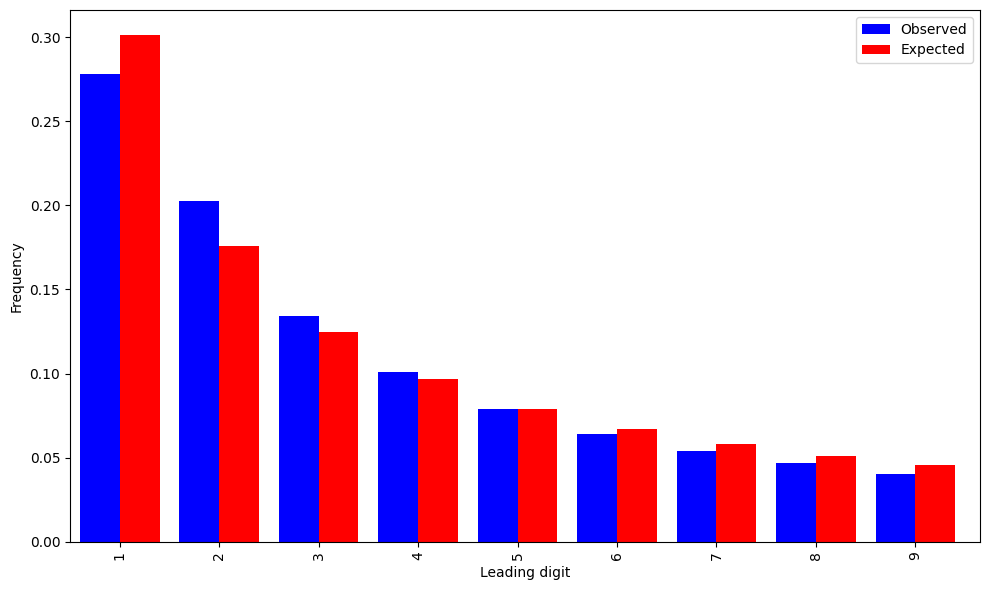

In [14]:
# Perform chi-square analysis and plot figures for each group
for group_name, observed_frequencies in group_frequencies.items():
    total_count = sum(observed_frequencies.values())
    
    # Calculate the expected frequency for each leading digit under the assumption of Benford's Law
    expected_frequencies_ben = {i: total_count * math.log10(1 + 1/i) for i in range(1, 10)}

    # Perform a chi-square test
    chi2_ben, p_ben = chisquare(list(observed_frequencies.values()), list(expected_frequencies_ben.values()))

    # Convert the frequencies to ratios
    observed_ratios = {k: v / total_count for k, v in observed_frequencies.items()}

    # Calculate expected frequencies according to Benford's law
    expected_frequencies = {i: math.log10(1 + 1 / i) for i in range(1, 10)}

    # Calculate the expected frequency for each leading digit under the assumption of Benford's Law
    probability_distribution_ben = expected_frequencies

    # Calculate the frequency for each leading digit under the observed dataset
    probability_distribution_obv = observed_ratios

    # Compute the MAD
    MAD = sum(abs(probability_distribution_obv[d] - probability_distribution_ben[d]) for d in range(1, 10)) / 9

    # Print the results for Benford's Law
    print(f"Results for {group_name}:")
    print(f"Chi-square statistic for Benford's Law expected frequency: {chi2_ben}")
    print(f"P-value for Benford's Law expected frequency: {p_ben}")
    print(f'{group_name} MAD: {MAD}')
    print("-" * 50)

    # Create a bar plot for Benford's Law
    plt.title(f'Observed and Benford\'s Law Expected for {group_name}')
    plt.bar(range(1, 10), [observed_frequencies.get(i, 0) for i in range(1, 10)], alpha=0.7, label='Observed')
    plt.bar(range(1, 10), [expected_frequencies_ben[i] for i in range(1, 10)], alpha=0.7, label='Expected')
    plt.xlabel('Leading Digit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Create a dataframe from the observed and expected ratios
    df = pd.DataFrame({'observed': observed_ratios, 'expected': expected_frequencies})

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    df['observed'].plot(kind='bar', color='blue', ax=ax, width=0.4, position=1, label='Observed')
    df['expected'].plot(kind='bar', color='red', ax=ax, width=0.4, position=0, label='Expected')

    ax.set_xlabel('Leading digit')
    ax.set_ylabel('Frequency')
    ax.set_xlim(left=-0.5)  
    plt.tight_layout() 
    plt.legend()
    plt.show()